In [3]:
# Load libraries
library(igraph)
library(ggplot2)
library(dplyr)
library(stringr)
library(tidyr)
library(RColorBrewer)
library(rgl)
library(sf)
library(readr)


Adjuntando el paquete: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Adjuntando el paquete: 'tidyr'


The following object is masked from 'package:igraph':

    crossing


Linking to GEOS 3.13.1, GDAL 3.11.0, PROJ 9.6.0; sf_use_s2() is TRUE



In [5]:
main_data_path <- "gadm1_nuts3_counties-gadm1_nuts3_counties - FB Social Connectedness Index - October 2021.tsv"
level_info_path <- "gadm1_nuts3_counties_levels.csv"

connect_data <- read.delim(main_data_path, sep = "\t", header = TRUE, stringsAsFactors = FALSE)

level_data <- read.csv(level_info_path, header = TRUE, stringsAsFactors = FALSE)

In [7]:
# Function to get country code
get_country_code <- function(key) {
  match <- str_extract(key, "^[A-Z]{2,3}")
  return(match)
}

connect_data$user_country <- sapply(connect_data$user_loc, get_country_code)
connect_data$fr_country <- sapply(connect_data$fr_loc, get_country_code)

connect_data_clean <- connect_data %>%
  filter(!is.na(user_country) & !is.na(fr_country))

In [9]:
# Function to make Facebook-style codes
makeFbCode <- function(countryISO, id1 = "", id2 = "", isUSA = FALSE) {
  code_part <- countryISO
  if (id1 != "") {
    if (isUSA) {
      state_padded <- sprintf("%02s", id1)
      county_padded <- if (id2 != "") sprintf("%03s", id2) else ""
      return(paste0(countryISO, state_padded, county_padded))
    }
    code_part <- paste0(code_part, id1)
  }
  if (id2 != "") {
    code_part <- paste0(code_part, "_", id2)
  }
  return(code_part)
}

In [11]:
my_data <- connect_data_clean %>%
  filter(user_country != "USA" & fr_country != "USA")

all_loc_keys <- unique(c(my_data$user_loc, my_data$fr_loc))

good_levels <- level_data %>%
  filter(level != "country") %>%
  select(key, level)

my_data_filtered <- my_data %>%
  semi_join(good_levels, by = c("user_loc" = "key")) %>%
  semi_join(good_levels, by = c("fr_loc" = "key"))


# Count nodes per country
country_node_info <- my_data_filtered %>%
  select(user_country, user_loc) %>%
  rename(country_code = user_country, loc_key = user_loc) %>%
  bind_rows(
    my_data_filtered %>%
      select(fr_country, fr_loc) %>%
      rename(country_code = fr_country, loc_key = fr_loc)
  ) %>%
  distinct(country_code, loc_key) %>%
  group_by(country_code) %>%
  summarise(node_count = n(), .groups = 'drop') %>%
  arrange(desc(node_count))

top_100_countries <- head(country_node_info$country_code, 100)

# Filter for final edges
final_connections <- my_data_filtered %>%
  filter(user_country %in% top_100_countries & fr_country %in% top_100_countries) %>%
  filter(user_country == fr_country) %>%
  filter(scaled_sci > 0)

# Final node labels
final_node_labels <- unique(c(final_connections$user_loc, final_connections$fr_loc))

In [13]:
# Create node mapping table
node_map <- data.frame(
  area_label = final_node_labels,
  node_id = 1:length(final_node_labels),
  stringsAsFactors = FALSE
)


In [15]:
# NUTS and GADM centroids 

nuts_shape_data <- tryCatch({
  st_read("NUTS_RG_20M_2024_3035.gpkg", quiet = TRUE) %>%
    st_transform(crs = 4326)
}, error = function(e) {
  NULL
})

nuts_coords_data <- data.frame(key = character(), longitude = numeric(), latitude = numeric(), stringsAsFactors = FALSE)

if (!is.null(nuts_shape_data) && nrow(nuts_shape_data) > 0) {
  nuts_centers <- nuts_shape_data %>%
    st_centroid(of_largest_polygon = TRUE) %>%
    st_coordinates()
  nuts_coords_data <- data.frame(
    key = nuts_shape_data$NUTS_ID,
    longitude = nuts_centers[, "X"],
    latitude = nuts_centers[, "Y"],
    stringsAsFactors = FALSE
  )
}

Warning message:
"st_centroid assumes attributes are constant over geometries"


In [17]:
gadm0_shp <- st_read("gadm28/gadm28_adm0.shp", quiet = TRUE)
gadm1_shp <- st_read("gadm28/gadm28_adm1.shp", quiet = TRUE)
gadm2_shp <- st_read("gadm28/gadm28_adm2.shp", quiet = TRUE)

# GADM coord storage
gadm_coord_data <- data.frame(key = character(), longitude = numeric(), latitude = numeric(), stringsAsFactors = FALSE)

# Process GADM0
if (!is.null(gadm0_shp) && nrow(gadm0_shp) > 0) {
  gadm0_shp <- st_make_valid(gadm0_shp)
  gadm0_processed <- gadm0_shp %>%
    mutate(CODE = sapply(ISO, function(x) makeFbCode(x))) %>%
    filter(CODE %in% level_data$key[level_data$level == "country"])

  if (nrow(gadm0_processed) > 0) {
    gadm0_centers <- gadm0_processed %>%
      st_transform(crs = 4326) %>%
      st_centroid(of_largest_polygon = TRUE) %>%
      st_coordinates()

    gadm_coord_data <- bind_rows(gadm_coord_data,
                                 data.frame(key = gadm0_processed$CODE,
                                            longitude = gadm0_centers[, "X"],
                                            latitude = gadm0_centers[, "Y"],
                                            stringsAsFactors = FALSE))
  }
}

# Process GADM1
if (!is.null(gadm1_shp) && nrow(gadm1_shp) > 0) {
  gadm1_shp <- st_make_valid(gadm1_shp)
  gadm1_processed <- gadm1_shp %>%
    mutate(CODE = mapply(makeFbCode, ISO, as.character(ID_1))) %>%
    filter(CODE %in% level_data$key[level_data$level == "gadm1"])

  if (nrow(gadm1_processed) > 0) {
    gadm1_centers <- gadm1_processed %>%
      st_transform(crs = 4326) %>%
      st_centroid(of_largest_polygon = TRUE) %>%
      st_coordinates()

    gadm_coord_data <- bind_rows(gadm_coord_data,
                                 data.frame(key = gadm1_processed$CODE,
                                            longitude = gadm1_centers[, "X"],
                                            latitude = gadm1_centers[, "Y"],
                                            stringsAsFactors = FALSE))
  }
}

# Process GADM2
if (!is.null(gadm2_shp) && nrow(gadm2_shp) > 0) {
  gadm2_shp <- st_make_valid(gadm2_shp)
  gadm2_processed <- gadm2_shp %>%
    mutate(CODE = mapply(makeFbCode, ISO, as.character(ID_1), as.character(ID_2))) %>%
    filter(CODE %in% level_data$key[level_data$level == "gadm2"])

  if (nrow(gadm2_processed) > 0) {
    gadm2_centers <- gadm2_processed %>%
      st_transform(crs = 4326) %>%
      st_centroid(of_largest_polygon = TRUE) %>%
      st_coordinates()

    gadm_coord_data <- bind_rows(gadm_coord_data,
                                 data.frame(key = gadm2_processed$CODE,
                                            longitude = gadm2_centers[, "X"],
                                            latitude = gadm2_centers[, "Y"],
                                            stringsAsFactors = FALSE))
  }
}

all_coords <- bind_rows(nuts_coords_data, gadm_coord_data) %>%
  distinct(key, .keep_all = TRUE)


Warning message:
"st_centroid assumes attributes are constant over geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


In [19]:
my_nodes <- node_map %>%
  left_join(all_coords, by = c("area_label" = "key")) %>%
  mutate(longitude = ifelse(is.na(longitude), 0, longitude),
         latitude = ifelse(is.na(latitude), 0, latitude))

In [21]:
country_mean_scis <- final_connections %>%
  filter(user_country %in% top_100_countries & fr_country %in% top_100_countries) %>%
  filter(user_country == fr_country) %>%
  group_by(country = user_country) %>%
  summarise(mean_sci = mean(scaled_sci, na.rm = TRUE), .groups = 'drop')

my_edges <- final_connections %>%
  left_join(country_mean_scis, by = c("user_country" = "country")) %>%
  filter(scaled_sci > mean_sci) %>%
  left_join(node_map, by = c("user_loc" = "area_label")) %>%
  rename(node_from = node_id) %>%
  left_join(node_map, by = c("fr_loc" = "area_label")) %>%
  rename(node_to = node_id) %>%
  select(
    node_from,
    node_to,
    country = user_country,
    scaled_sci
  ) %>%
  filter(node_from != node_to) %>%
  rowwise() %>%
  mutate(
    temp_node1 = min(node_from, node_to),
    temp_node2 = max(node_from, node_to)
  ) %>%
  ungroup() %>%
  distinct(temp_node1, temp_node2, .keep_all = TRUE) %>%
  select(node_from, node_to, country, scaled_sci)

In [23]:
write.csv(my_nodes %>% select(node_id, area_label, latitude, longitude), "my_nodes.csv", row.names = FALSE)
write.csv(my_edges, "my_edges.csv", row.names = FALSE)

In [25]:
my_nodes_data <- read.csv("my_nodes.csv", header = TRUE, stringsAsFactors = FALSE)
my_edges_data <- read.csv("my_edges.csv", header = TRUE, stringsAsFactors = FALSE)

In [27]:
node_country_mapping <- data.frame(
  area_label = final_node_labels,
  country = sapply(final_node_labels, get_country_code),
  stringsAsFactors = FALSE
) %>%
  left_join(node_map, by = "area_label") %>%
  select(node_id, area_label, country) %>%
  filter(country %in% top_100_countries)

# True node counts per country
real_node_counts <- node_country_mapping %>%
  group_by(country) %>%
  summarise(TrueNodes = n(), .groups = 'drop')


In [29]:
# Network Analysis

country_networks_data <- my_edges_data %>%
  group_by(country) %>%
  nest() %>%
  rename(country_edges = data)

network_results <- data.frame(
  Country = character(),
  NodesCount = integer(),
  EdgesCount = integer(),
  NetworkDensity = numeric(),
  AvgPathLen = numeric(),
  ClusteringCoeff = numeric(),
  NumComponents = integer(),
  stringsAsFactors = FALSE
)


for (i in 1:nrow(country_networks_data)) {
  current_country <- country_networks_data$country[i]
  country_edges_data <- country_networks_data$country_edges[[i]]

  true_nodes_for_country <- real_node_counts %>%
    filter(country == current_country) %>%
    pull(TrueNodes)

  if (nrow(country_edges_data) == 0) {
    network_results <- rbind(network_results, data.frame(
      Country = current_country,
      NodesCount = true_nodes_for_country,
      EdgesCount = 0,
      NetworkDensity = 0,
      AvgPathLen = NA_real_,
      ClusteringCoeff = 0,
      NumComponents = true_nodes_for_country,
      stringsAsFactors = FALSE
    ))
    next
  }

  my_graph <- graph_from_data_frame(country_edges_data[, c("node_from", "node_to")], directed = FALSE)

  num_edges_in_graph <- ecount(my_graph)

  max_possible_edges <- true_nodes_for_country * (true_nodes_for_country - 1) / 2
  density_val <- ifelse(max_possible_edges > 0, num_edges_in_graph / max_possible_edges, 0)

  graph_components <- components(my_graph)
  num_graph_components <- graph_components$no

  avg_path_length_val <- NA_real_
  if (num_graph_components == 1) {
    if (vcount(my_graph) > 1) {
      avg_path_length_val <- mean_distance(my_graph, directed = FALSE)
    } else {
      avg_path_length_val <- 0
    }
  } else if (num_graph_components > 1) {
    biggest_comp_id <- which.max(graph_components$csize)
    biggest_comp_nodes <- V(my_graph)[graph_components$membership == biggest_comp_id]
    subgraph_biggest_comp <- induced_subgraph(my_graph, biggest_comp_nodes)
    if (vcount(subgraph_biggest_comp) > 1) {
      avg_path_length_val <- mean_distance(subgraph_biggest_comp, directed = FALSE)
    }
  }

  clustering_coeff_val <- transitivity(my_graph, type = "global")
  if (is.nan(clustering_coeff_val)) {
    clustering_coeff_val <- 0
  }

  network_results <- rbind(network_results, data.frame(
    Country = current_country,
    NodesCount = true_nodes_for_country,
    EdgesCount = num_edges_in_graph,
    NetworkDensity = density_val,
    AvgPathLen = avg_path_length_val,
    ClusteringCoeff = clustering_coeff_val,
    NumComponents = num_graph_components,
    stringsAsFactors = FALSE
  ))
}

In [35]:
print(network_results)

   Country NodesCount EdgesCount NetworkDensity AvgPathLen ClusteringCoeff
1      AGO         18          4    0.026143791   1.333333       0.0000000
2       AL         12          1    0.015151515   1.000000       0.0000000
3      ARG         24          3    0.010869565   1.000000       0.0000000
4       AT         35         31    0.052100840   2.311111       0.3571429
5      BDI         17          3    0.022058824   1.333333       0.0000000
6       BE         44         94    0.099365751   4.090476       0.5185185
7       BG         28         10    0.026455026   1.666667       0.0000000
8      BGD         64        108    0.053571429   4.782745       0.4670659
9      BRA         27          7    0.019943020   1.666667       0.0000000
10     BWA         15         10    0.095238095   2.071429       0.3529412
11     CAF         14          4    0.043956044   1.000000       0.0000000
12     CAN        293       2188    0.051147786   4.243945       0.6551942
13      CH         26    

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


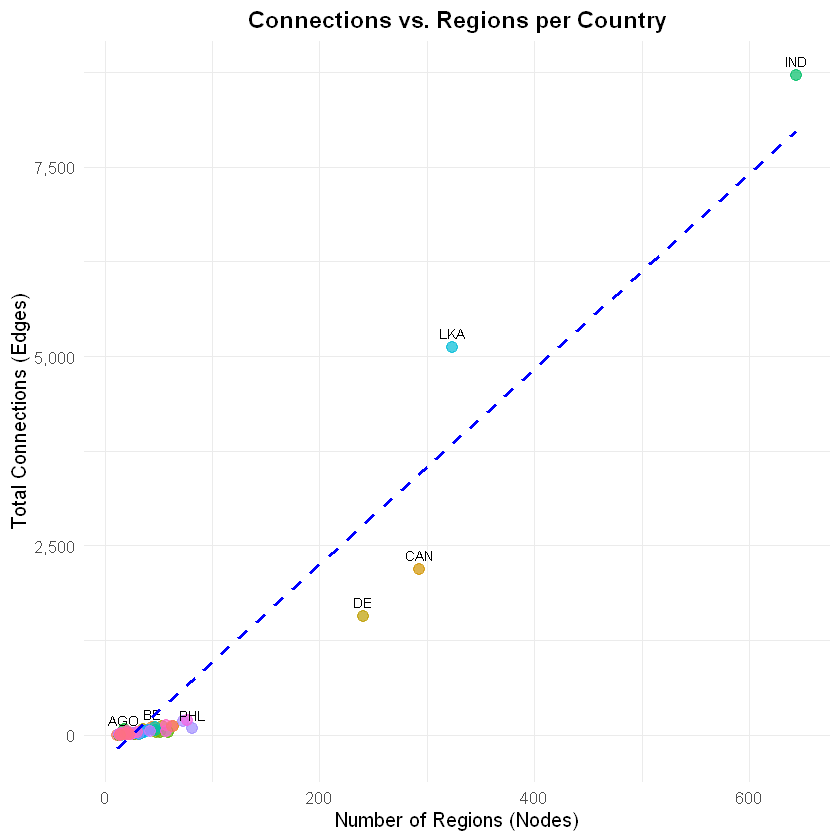

In [31]:
# Plot: Edges vs Nodes
plot_edges_nodes <- ggplot(network_results, aes(x = NodesCount, y = EdgesCount)) +
  geom_point(aes(color = Country), size = 3, alpha = 0.7) +
  geom_text(aes(label = Country), vjust = -0.8, hjust = 0.5, size = 3, check_overlap = TRUE) +
  labs(
    title = "Connections vs. Regions per Country",
    x = "Number of Regions (Nodes)",
    y = "Total Connections (Edges)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    legend.position = "none"
  ) +
  geom_smooth(method = "lm", se = FALSE, color = "blue", linetype = "dashed") +
  scale_x_continuous(labels = scales::comma) +
  scale_y_continuous(labels = scales::comma)

print(plot_edges_nodes)
ggsave("edges_vs_nodes_plot.pdf", plot = plot_edges_nodes, width = 10, height = 7)

[1] "Degree Distribution for IND"
   Degree Frequency
1       3         2
2       6         6
3       7         6
4       8        15
5       9        15
6      10        12
7      11        29
8      12        26
9      13        25
10     14        23
11     15        40
12     16        39
13     17        23
14     18        24
15     19        24
16     20        19
17     21        19
18     22        22
19     23        16
20     24        20
21     25        17
22     26        11
23     27        16
24     28        13
25     29        11
26     30        18
27     31        12
28     32        19
29     33         7
30     34         4
31     35         3
32     36         4
33     37         4
34     38         1
35     40         3
36     41         2
37     42         2
38     44         1
39     45         1
40     46         1
41     49         1
42     50         1
43     51         3
44     52         1
45     53         2
46     54         4
47     55         1
48    

`geom_smooth()` using formula = 'y ~ x'


[1] "Plotting IND network..."


`geom_smooth()` using formula = 'y ~ x'


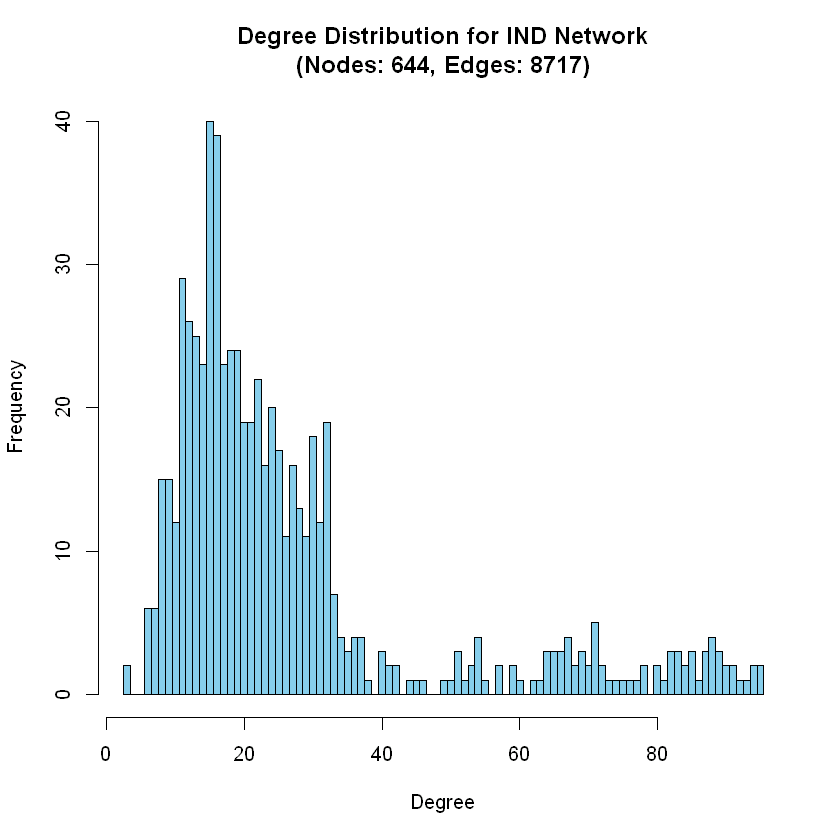

[1] "Degree Distribution for RS"
  Degree Frequency
1      1        11
2      2         2
3      3         1


`geom_smooth()` using formula = 'y ~ x'


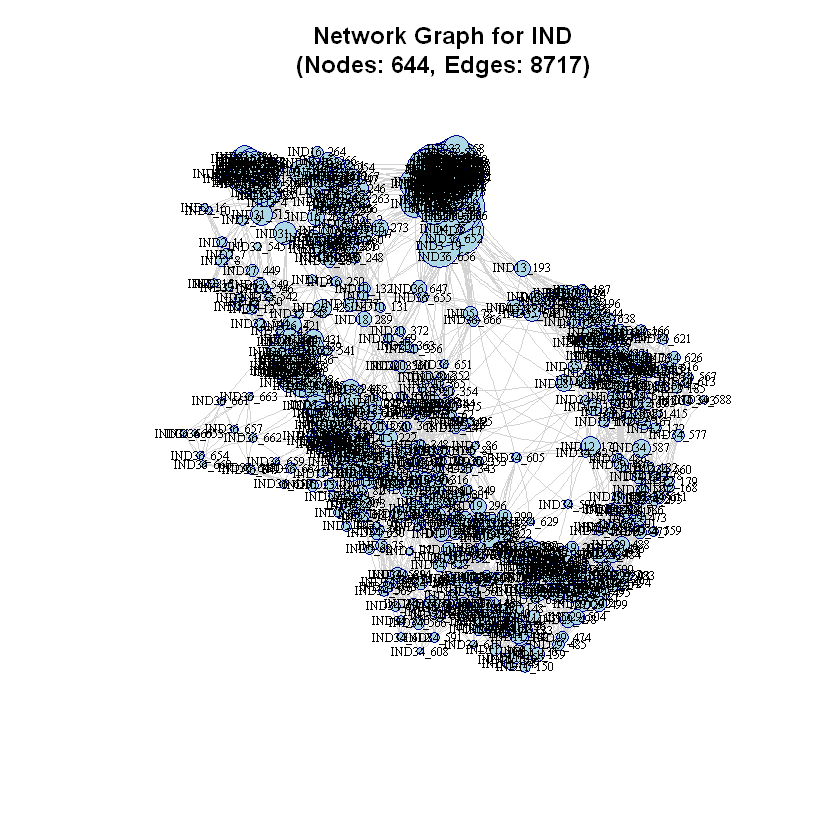

[1] "Plotting RS network..."


`geom_smooth()` using formula = 'y ~ x'


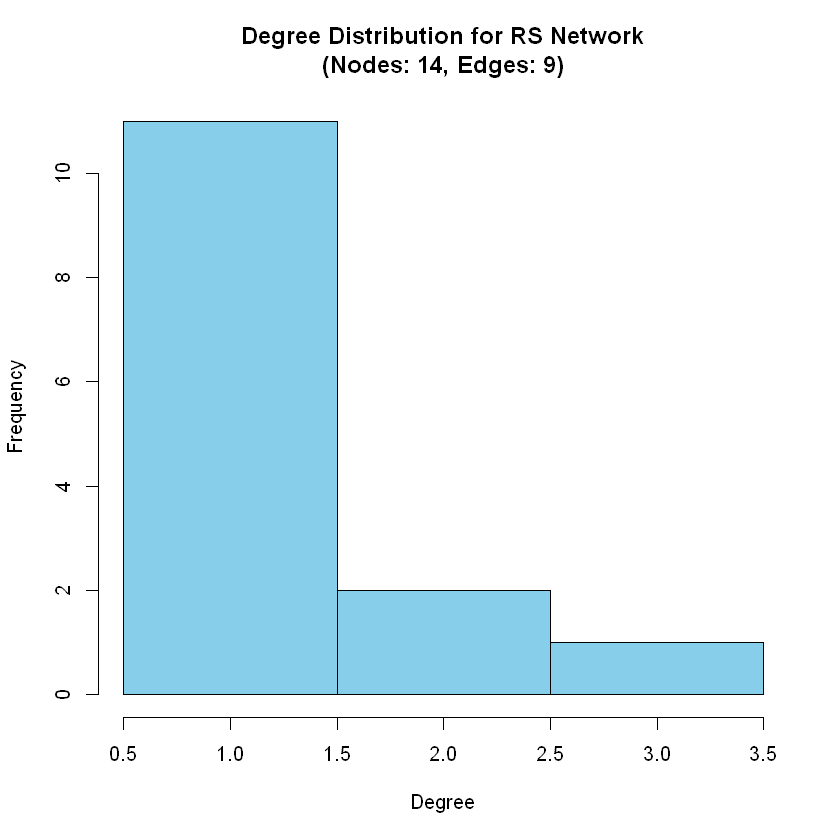

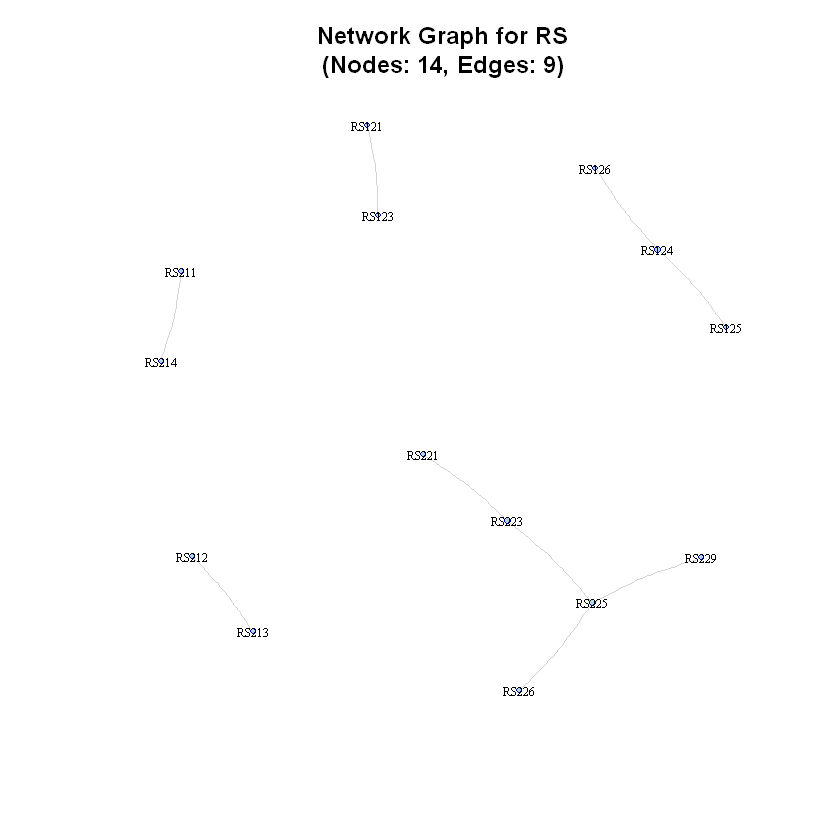

In [33]:
# IND vs RS
country_graphs <- list()
for (i in 1:nrow(country_networks_data)) {
  country_code <- country_networks_data$country[i]
  country_edges_data <- country_networks_data$country_edges[[i]]
  if (nrow(country_edges_data) > 0) {
    country_graphs[[country_code]] <- graph_from_data_frame(country_edges_data[, c("node_from", "node_to")], directed = FALSE)
  }
}

countries_for_detail <- c("IND", "RS")

for (country_code in countries_for_detail) {
  my_country_graph <- country_graphs[[country_code]]

  if (!is.null(my_country_graph) && vcount(my_country_graph) > 0) {
    country_degrees <- degree(my_country_graph, mode = "all")

    degree_counts_df <- as.data.frame(table(country_degrees))
    names(degree_counts_df) <- c("Degree", "Frequency")
    print(paste("Degree Distribution for", country_code))
    print(degree_counts_df)

    hist_title <- paste0("Degree Distribution for ", country_code, " Network\n(Nodes: ", vcount(my_country_graph), ", Edges: ", ecount(my_country_graph), ")")

    hist(country_degrees, breaks = seq(min(country_degrees)-0.5, max(country_degrees)+0.5, by = 1),
         main = hist_title,
         xlab = "Degree",
         ylab = "Frequency",
         col = "skyblue", border = "black")
    
    ggsave(paste0(country_code, "_degree_distribution.pdf"), plot = last_plot(), width = 8, height = 6)

    print(paste("Plotting", country_code, "network..."))

    country_node_labels <- node_map %>%
      filter(node_id %in% V(my_country_graph)$name) %>%
      select(node_id, area_label)

    V(my_country_graph)$label <- country_node_labels$area_label[match(V(my_country_graph)$name, country_node_labels$node_id)]

    V(my_country_graph)$size <- degree(my_country_graph) / 5 + 2

    E(my_country_graph)$width <- 0.5
    E(my_country_graph)$color <- "lightgray"

    graph_layout <- layout_with_fr(my_country_graph)

    plot_title_graph <- paste0("Network Graph for ", country_code, "\n(Nodes: ", vcount(my_country_graph), ", Edges: ", ecount(my_country_graph), ")")

    plot(my_country_graph,
         layout = graph_layout,
         vertex.color = "lightblue",
         vertex.frame.color = "darkblue",
         vertex.label.color = "black",
         vertex.label.cex = 0.6,
         vertex.label.dist = 0,
         edge.curved = 0.1,
         main = plot_title_graph)
    
    ggsave(paste0(country_code, "_network_graph.pdf"), plot = last_plot(), width = 10, height = 8)

  } else {
    print(paste(country_code, "graph is empty or not found."))
  }
}